In [ ]:
!pip install xgboost catboost shap optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.6 MB/s eta 0:00:00


# **Importing Necessary Libraries:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

import optuna
from optuna.samplers import TPESampler

from google.colab import drive
drive.mount('/content/drive')

RANDOM_STATE = 42

Mounted at /content/drive


#**Loading the dataset:**

In [ ]:
data = pd.read_csv('/content/drive/My Drive/finaldataset.csv')
from sklearn.neighbors import NearestNeighbors

data = data.drop(columns=["S. No."])
data['Liver Healthy'] = data['Liver Healthy'].map({'Yes': 1, 'No': 0, 'Mid' : 1}).astype(int)

df_features = data.drop(columns=["Liver Healthy"])
df_labels = data["Liver Healthy"]

# Dataset A: Noise-Augmented with varied noise distributions
def generate_dataset_with_noise_improved(df, labels, n_samples=100, noise_level_numeric=0.05, noise_level_categorical=0.01):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    new_data = []
    new_labels = []
    for _ in range(n_samples):
        idx = np.random.randint(0, len(df))
        row = df.iloc[idx].copy()
        label = labels.iloc[idx]

        for col in numeric_cols:
            noise_type = np.random.choice(['normal', 'uniform'])
            if noise_type == 'normal':
                noise = np.random.normal(0, noise_level_numeric * df[col].std())
            else:
                noise = np.random.uniform(-noise_level_numeric * df[col].std(), noise_level_numeric * df[col].std())
            row[col] += noise
            if col == "Age":
                row[col] = int(round(row[col]))
        # Add noise to categorical features (randomly flip a small percentage)
        for col in cat_cols:
            if np.random.rand() < noise_level_categorical:
                unique_values = df[col].unique()
                row[col] = np.random.choice(unique_values)
        # Ensure numeric values stay within original range
        for col in numeric_cols:
            row[col] = np.clip(row[col], df[col].min(), df[col].max())
        new_data.append(row)
        new_labels.append(label)
    df_aug = pd.DataFrame(new_data)
    df_aug['Liver Healthy'] = new_labels
    return df_aug

# Dataset B: Class-wise Statistical Sampling with added randomness
def generate_dataset_statistical_improved(df, labels, n_samples=100):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    df_0 = df[labels == 0]
    df_1 = df[labels == 1]
    data_gen = []
    labels_gen = []
    for _ in range(n_samples):
        label = np.random.choice([0, 1])
        source_df = df_0 if label == 0 else df_1
        new_row = {}
        for col in numeric_cols:
            mu = source_df[col].mean()
            sigma = source_df[col].std()
            val = np.random.normal(mu, sigma) * np.random.uniform(0.8, 1.2)
            val = np.clip(val, df[col].min(), df[col].max())
            new_row[col] = int(round(val)) if col == "Age" else val
        for col in cat_cols:
             if not source_df[col].empty:
                new_row[col] = source_df[col].sample(n=1, replace=True).values[0]
             else:
                new_row[col] = df[col].sample(n=1, replace=True).values[0]
        data_gen.append(new_row)
        labels_gen.append(label)
    df_generated = pd.DataFrame(data_gen)
    df_generated['Liver Healthy'] = labels_gen
    return df_generated

# Dataset C: SMOTE-like Interpolation with extrapolation
def generate_dataset_interpolation_extrapolation(df, labels, n_samples=100, k=3, extrapolation_factor=0.2):
    numeric_df = df.select_dtypes(include=[np.number])
    categorical_df = df.select_dtypes(exclude=[np.number])
    new_data = []
    new_labels = []
    for label in [0, 1]:
        df_label = numeric_df[labels == label].reset_index(drop=True)
        cats_label = categorical_df[labels == label].reset_index(drop=True)
        if len(df_label) > k:
            nbrs = NearestNeighbors(n_neighbors=k+1).fit(df_label)
            for _ in range(n_samples // 2):
                idx = np.random.randint(0, len(df_label))
                _, indices = nbrs.kneighbors([df_label.iloc[idx]])
                neighbor_idx = np.random.choice(indices[0][1:])
                row1 = df_label.iloc[idx]
                row2 = df_label.iloc[neighbor_idx]
                alpha = np.random.uniform(-extrapolation_factor, 1 + extrapolation_factor)
                interp_row = row1 + alpha * (row2 - row1)
                interp_row["Age"] = int(round(interp_row["Age"]))
                for col in numeric_df.columns:
                    interp_row[col] = np.clip(interp_row[col], df[col].min(), df[col].max())
                cat_row = cats_label.iloc[idx].copy()
                combined = pd.concat([interp_row, cat_row])
                new_data.append(combined)
                new_labels.append(label)
        else:
            for _ in range(n_samples // 2):
                idx = np.random.randint(0, len(df_label))
                combined = pd.concat([df_label.iloc[idx], cats_label.iloc[idx]])
                new_data.append(combined)
                new_labels.append(label)


    df_interp = pd.DataFrame(new_data)
    df_interp['Liver Healthy'] = new_labels
    return df_interp

dataset_a = generate_dataset_with_noise_improved(df_features, df_labels, n_samples=250)
dataset_b = generate_dataset_statistical_improved(df_features, df_labels, n_samples=250)
dataset_c = generate_dataset_interpolation_extrapolation(df_features, df_labels, n_samples=250)

df = pd.concat([data, dataset_a, dataset_b, dataset_c], ignore_index=True)

print(df.describe())
print(df.info())
print(df.head())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

              Age            R            G            B            C  \
count  846.000000   846.000000   846.000000   846.000000   846.000000   
mean    31.653664   742.240860   514.853799   324.981237  1538.842039   
std     18.496490   526.994764   369.144887   232.308118  1083.137988   
min     19.000000    54.000000    29.570000    20.570000    96.710000   
25%     20.000000   308.363369   186.472327   124.023187   609.782756   
50%     21.000000   593.796217   401.019692   244.428190  1213.544128   
75%     39.000000  1071.469800   830.869394   520.426731  2462.521450   
max     85.000000  2058.830000  1554.290000  1095.860000  4302.710000   

        Temp90614   Temp90640          GSR         BMI  Liver Healthy  
count  846.000000  846.000000   846.000000  846.000000     846.000000  
mean    31.214338   34.352287   435.808628   24.137263       0.594563  
std      3.405128    3.416452   349.425490    4.411592       0.491267  
min     22.170000   24.140000     9.570000   14.490000

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

# **Yellowness Index Calculation:**

In [ ]:
R, G, B, C = df["R"].astype(float), df["G"].astype(float), df["B"].astype(float), df["C"].astype(float)

rgb = np.stack([R, G, B], axis=1)
C_array = C.to_numpy().reshape(-1, 1)
rgb_norm = rgb / np.clip(C_array, 1e-6, None)

gray_world_avg = np.mean(rgb_norm, axis=0)
rgb_balanced = np.clip(rgb_norm / gray_world_avg, 0, 1)

gamma = 2.2
rgb_linear = np.power(rgb_balanced, gamma)

M_sRGB_D65 = np.array([
    [0.4124564, 0.3575761, 0.1804375],
    [0.2126729, 0.7151522, 0.0721750],
    [0.0193339, 0.1191920, 0.9503041]
])
xyz = rgb_linear @ M_sRGB_D65.T
X, Y, Z = xyz[:, 0], xyz[:, 1], xyz[:, 2]

scaler_xyz = RobustScaler()
X_scaled, Y_scaled, Z_scaled = scaler_xyz.fit_transform(np.stack([X, Y, Z], axis=1)).T

Cx, Cz = 1.2769, 1.0592
YI_raw = 100 * (Cx * X_scaled - Cz * Z_scaled) / np.clip(Y_scaled, 1e-6, None)
df["Yellowness Index"] = (YI_raw - YI_raw.min()) / (YI_raw.max() - YI_raw.min())

df.drop(["R", "G", "B", "C"], axis=1, inplace=True)

# **Encoding:**

In [ ]:
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0}).astype(float)
df.rename(columns={"Temp90614": "BodyTemp", "Temp90640": "LiverTemp"}, inplace=True)

print("\nClass Distribution:")
print(df["Liver Healthy"].value_counts(normalize=True))

X = df.drop(["Liver Healthy"], axis=1)
y = df["Liver Healthy"]


Class Distribution:
Liver Healthy
1    0.594563
0    0.405437
Name: proportion, dtype: float64


# **Train-Test Split:**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Correlation Matrix:**

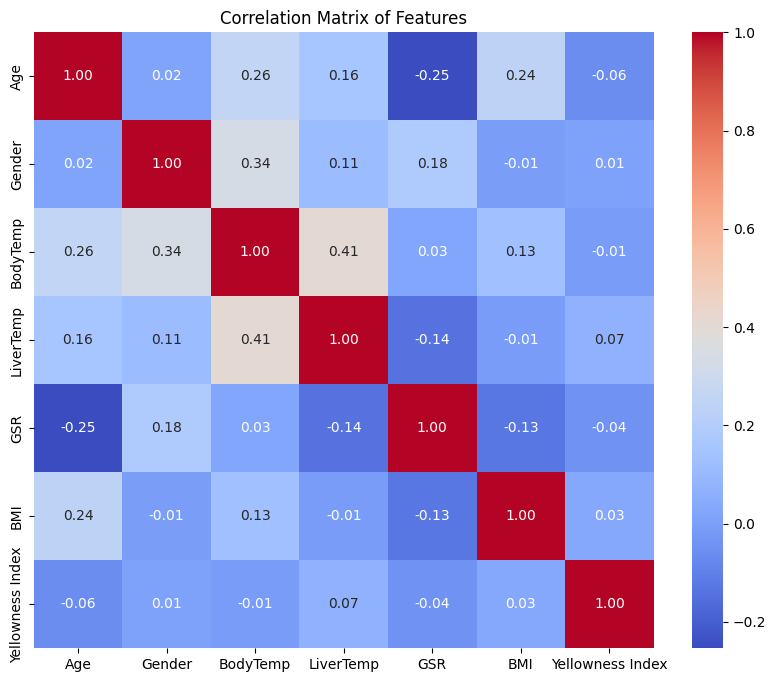

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()

# **Hyperparameter Tuning:**

In [ ]:
def tune_model(trial, model_name):
    if model_name == "RandomForest":
        return RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 500),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
            class_weight="balanced",
            random_state=RANDOM_STATE,
        )
    elif model_name == "LogisticRegression":
        return LogisticRegression(
            C=trial.suggest_float("C", 0.001, 10, log=True),
            penalty="l2",
            solver="lbfgs",
            max_iter=1000,
            class_weight="balanced",
        )
    elif model_name == "SVM_RBF":
        return SVC(
            kernel="rbf",
            C=trial.suggest_float("C", 0.1, 10, log=True),
            gamma=trial.suggest_categorical("gamma", ["scale", "auto"]),
            probability=True,
            class_weight="balanced",
        )
    elif model_name == "SVM_Poly":
        return SVC(
            kernel="poly",
            C=trial.suggest_float("C", 0.1, 10, log=True),
            degree=trial.suggest_int("degree", 2, 5),
            probability=True,
            class_weight="balanced",
        )
    elif model_name == "XGBoost":
        return XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 500),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            eval_metric="logloss",
            random_state=RANDOM_STATE,
        )
    elif model_name == "CatBoost":
        return CatBoostClassifier(
            iterations=trial.suggest_int("iterations", 100, 500),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            depth=trial.suggest_int("depth", 4, 10),
            verbose=0,
            random_state=RANDOM_STATE,
        )

def objective(trial, model_name):
    model = tune_model(trial, model_name)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        model.fit(X_train[train_idx], y_train.iloc[train_idx])
        y_proba = model.predict_proba(X_train[val_idx])[:, 1]
        scores.append(roc_auc_score(y_train.iloc[val_idx], y_proba))
    return np.nanmean(scores)

models_to_tune = ["RandomForest", "LogisticRegression", "SVM_RBF", "SVM_Poly", "XGBoost", "CatBoost"]
best_estimators = {}

for model_name in models_to_tune:
    print(f"\nTuning {model_name}...")
    study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=RANDOM_STATE))
    study.optimize(lambda trial: objective(trial, model_name), n_trials=50, show_progress_bar=False)
    best_estimators[model_name] = tune_model(study.best_trial, model_name)
    best_estimators[model_name].fit(X_train, y_train)

[I 2025-07-29 15:44:00,555] A new study created in memory with name: no-name-5e73a547-3b96-4a0e-9810-e6a3748ba3f0



Tuning RandomForest...


[I 2025-07-29 15:44:09,088] Trial 0 finished with value: 0.9445321112358149 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9445321112358149.
[I 2025-07-29 15:44:13,623] Trial 1 finished with value: 0.9252511742943842 and parameters: {'n_estimators': 162, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9445321112358149.
[I 2025-07-29 15:44:25,816] Trial 2 finished with value: 0.9407094816477531 and parameters: {'n_estimators': 341, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9445321112358149.
[I 2025-07-29 15:44:32,337] Trial 3 finished with value: 0.9385207424034585 and parameters: {'n_estimators': 433, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9445321112358149.
[I 2025-07-29 15:44:34,986] Trial 4 finished with value: 0.9481179490377022 and parameters: {'


Tuning LogisticRegression...


[I 2025-07-29 15:48:06,139] Trial 3 finished with value: 0.8414580579457123 and parameters: {'C': 0.24810409748678125}. Best is trial 1 with value: 0.8420503387787338.
[I 2025-07-29 15:48:06,197] Trial 4 finished with value: 0.8344845990771915 and parameters: {'C': 0.004207988669606638}. Best is trial 1 with value: 0.8420503387787338.
[I 2025-07-29 15:48:06,256] Trial 5 finished with value: 0.8344845990771915 and parameters: {'C': 0.004207053950287938}. Best is trial 1 with value: 0.8420503387787338.
[I 2025-07-29 15:48:06,304] Trial 6 finished with value: 0.8308880159620899 and parameters: {'C': 0.0017073967431528124}. Best is trial 1 with value: 0.8420503387787338.
[I 2025-07-29 15:48:06,354] Trial 7 finished with value: 0.8421420792284989 and parameters: {'C': 2.9154431891537547}. Best is trial 7 with value: 0.8421420792284989.
[I 2025-07-29 15:48:06,403] Trial 8 finished with value: 0.8413668786631749 and parameters: {'C': 0.2537815508265665}. Best is trial 7 with value: 0.84214207


Tuning SVM_RBF...


[I 2025-07-29 15:48:09,021] Trial 0 finished with value: 0.8905868977844286 and parameters: {'C': 0.5611516415334505, 'gamma': 'scale'}. Best is trial 0 with value: 0.8905868977844286.
[I 2025-07-29 15:48:09,269] Trial 1 finished with value: 0.903444984827701 and parameters: {'C': 1.5751320499779735, 'gamma': 'scale'}. Best is trial 1 with value: 0.903444984827701.
[I 2025-07-29 15:48:09,569] Trial 2 finished with value: 0.8585806002410941 and parameters: {'C': 0.13066739238053282, 'gamma': 'scale'}. Best is trial 1 with value: 0.903444984827701.
[I 2025-07-29 15:48:09,827] Trial 3 finished with value: 0.9065682961300245 and parameters: {'C': 2.607024758370768, 'gamma': 'auto'}. Best is trial 3 with value: 0.9065682961300245.
[I 2025-07-29 15:48:10,214] Trial 4 finished with value: 0.9152022280417341 and parameters: {'C': 4.622589001020832, 'gamma': 'scale'}. Best is trial 4 with value: 0.9152022280417341.
[I 2025-07-29 15:48:10,752] Trial 5 finished with value: 0.8697090036164111 and 


Tuning SVM_Poly...


[I 2025-07-29 15:48:24,001] Trial 0 finished with value: 0.8594017957351291 and parameters: {'C': 0.5611516415334505, 'degree': 5}. Best is trial 0 with value: 0.8594017957351291.
[I 2025-07-29 15:48:24,266] Trial 1 finished with value: 0.8104946377353786 and parameters: {'C': 2.9106359131330697, 'degree': 4}. Best is trial 0 with value: 0.8594017957351291.
[I 2025-07-29 15:48:24,681] Trial 2 finished with value: 0.69684122085048 and parameters: {'C': 0.20513382630874505, 'degree': 2}. Best is trial 0 with value: 0.8594017957351291.
[I 2025-07-29 15:48:25,158] Trial 3 finished with value: 0.8350474705906805 and parameters: {'C': 0.13066739238053282, 'degree': 5}. Best is trial 0 with value: 0.8594017957351291.
[I 2025-07-29 15:48:25,622] Trial 4 finished with value: 0.8104424907511326 and parameters: {'C': 1.5930522616241019, 'degree': 4}. Best is trial 0 with value: 0.8594017957351291.
[I 2025-07-29 15:48:26,080] Trial 5 finished with value: 0.8325724841002617 and parameters: {'C': 0.


Tuning XGBoost...


[I 2025-07-29 15:48:43,454] Trial 0 finished with value: 0.9400006235191419 and parameters: {'n_estimators': 250, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 0.9400006235191419.
[I 2025-07-29 15:48:44,452] Trial 1 finished with value: 0.9341227085671531 and parameters: {'n_estimators': 162, 'learning_rate': 0.012184186502221764, 'max_depth': 9, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181}. Best is trial 0 with value: 0.9400006235191419.
[I 2025-07-29 15:48:44,807] Trial 2 finished with value: 0.9420229662883983 and parameters: {'n_estimators': 108, 'learning_rate': 0.2708160864249968, 'max_depth': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}. Best is trial 2 with value: 0.9420229662883983.
[I 2025-07-29 15:48:45,578] Trial 3 finished with value: 0.9411829405162739 and parameters: {'n_estimators': 173, 'learning_rate': 


Tuning CatBoost...


[I 2025-07-29 15:49:57,456] Trial 0 finished with value: 0.9554562289562292 and parameters: {'iterations': 250, 'learning_rate': 0.2536999076681772, 'depth': 9}. Best is trial 0 with value: 0.9554562289562292.
[I 2025-07-29 15:50:00,137] Trial 1 finished with value: 0.936072411356362 and parameters: {'iterations': 340, 'learning_rate': 0.01700037298921102, 'depth': 5}. Best is trial 0 with value: 0.9554562289562292.
[I 2025-07-29 15:50:03,897] Trial 2 finished with value: 0.9472863199900237 and parameters: {'iterations': 123, 'learning_rate': 0.19030368381735815, 'depth': 8}. Best is trial 0 with value: 0.9554562289562292.
[I 2025-07-29 15:50:42,444] Trial 3 finished with value: 0.9511708650288897 and parameters: {'iterations': 383, 'learning_rate': 0.010725209743171997, 'depth': 10}. Best is trial 0 with value: 0.9554562289562292.
[I 2025-07-29 15:50:45,915] Trial 4 finished with value: 0.9434480400714967 and parameters: {'iterations': 433, 'learning_rate': 0.020589728197687916, 'dept

# **Evaluation parameters (model-wise):**


Evaluation of RandomForest
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        69
           1       0.88      0.90      0.89       101

    accuracy                           0.87       170
   macro avg       0.87      0.86      0.87       170
weighted avg       0.87      0.87      0.87       170

ROC-AUC: 0.9417


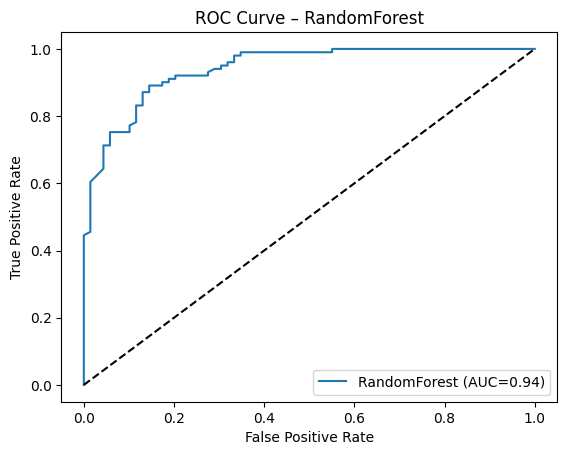


Evaluation of LogisticRegression
              precision    recall  f1-score   support

           0       0.71      0.81      0.76        69
           1       0.86      0.77      0.81       101

    accuracy                           0.79       170
   macro avg       0.78      0.79      0.78       170
weighted avg       0.80      0.79      0.79       170

ROC-AUC: 0.8521


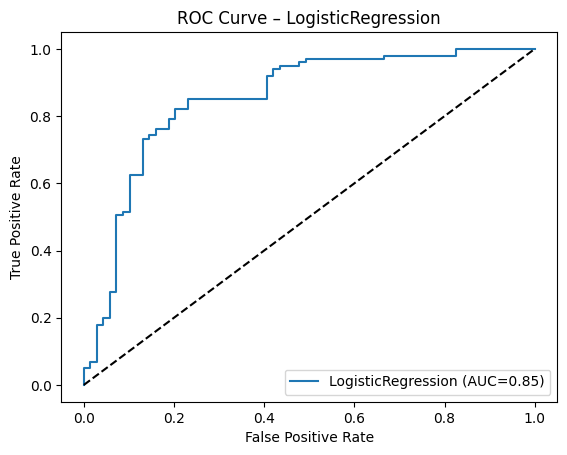


Evaluation of SVM_RBF
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        69
           1       0.85      0.80      0.83       101

    accuracy                           0.80       170
   macro avg       0.79      0.80      0.80       170
weighted avg       0.80      0.80      0.80       170

ROC-AUC: 0.8687


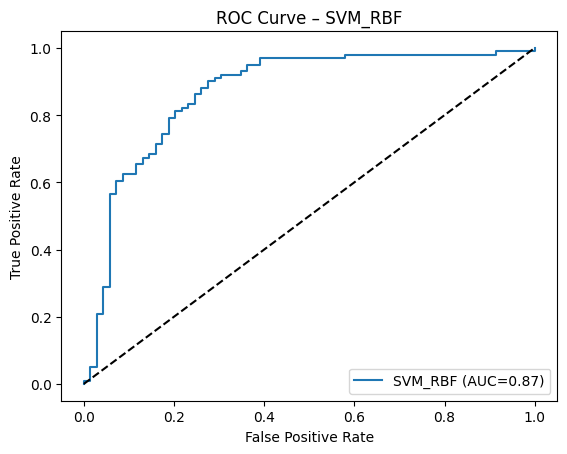


Evaluation of SVM_Poly
              precision    recall  f1-score   support

           0       0.82      0.81      0.82        69
           1       0.87      0.88      0.88       101

    accuracy                           0.85       170
   macro avg       0.85      0.85      0.85       170
weighted avg       0.85      0.85      0.85       170

ROC-AUC: 0.8579


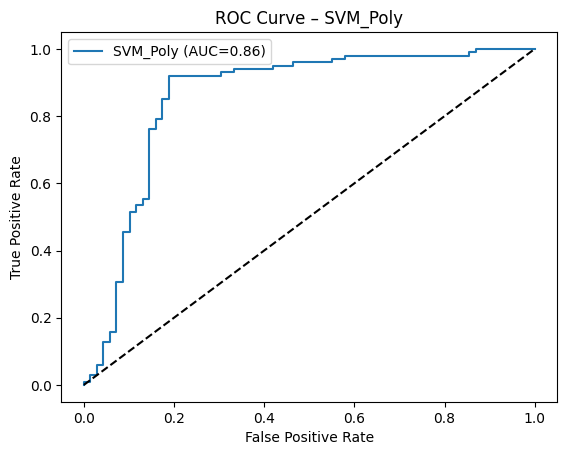


Evaluation of XGBoost
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        69
           1       0.87      0.89      0.88       101

    accuracy                           0.86       170
   macro avg       0.85      0.85      0.85       170
weighted avg       0.86      0.86      0.86       170

ROC-AUC: 0.9383


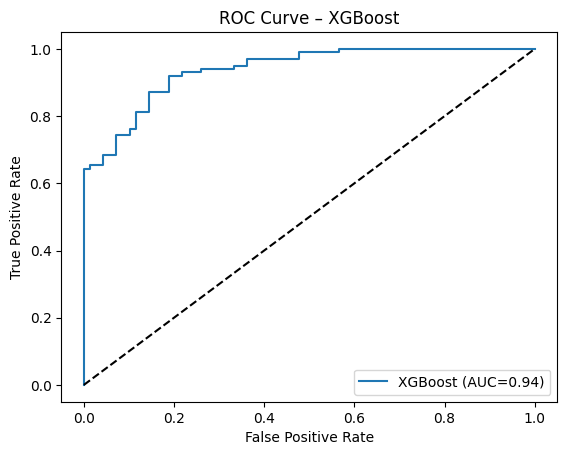


Evaluation of CatBoost
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        69
           1       0.87      0.89      0.88       101

    accuracy                           0.86       170
   macro avg       0.85      0.85      0.85       170
weighted avg       0.86      0.86      0.86       170

ROC-AUC: 0.9321


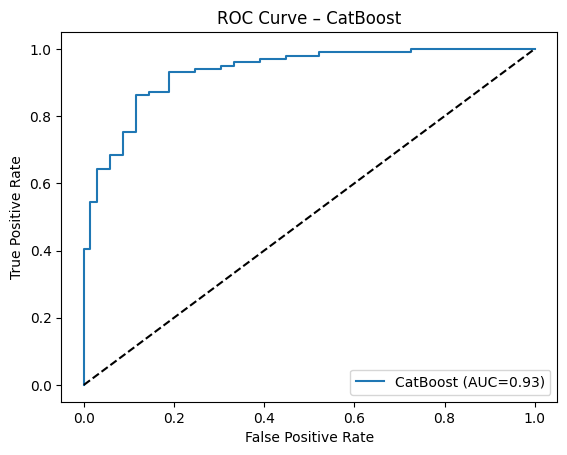

In [ ]:
for name, model in best_estimators.items():
    print(f"\nEvaluation of {name}")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {name}")
    plt.legend()
    plt.show()

# **Ensembling:**


✅ Stacked Model Classification Report
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        69
           1       0.89      0.89      0.89       101

    accuracy                           0.87       170
   macro avg       0.87      0.87      0.87       170
weighted avg       0.87      0.87      0.87       170

Stacked Model ROC-AUC: 0.9384


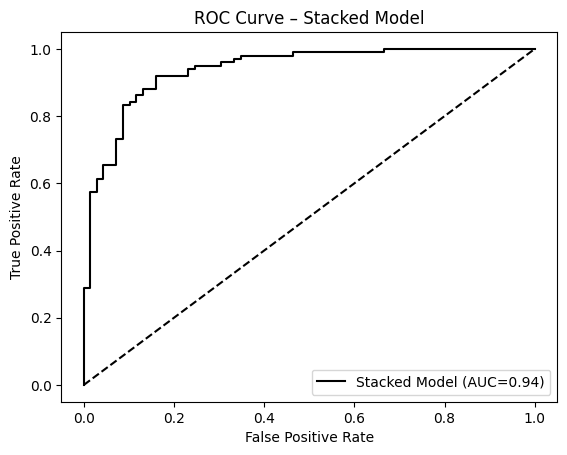


✅ Voting Classifier Classification Report
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        69
           1       0.88      0.90      0.89       101

    accuracy                           0.86       170
   macro avg       0.86      0.86      0.86       170
weighted avg       0.86      0.86      0.86       170

Voting Classifier ROC-AUC: 0.9290


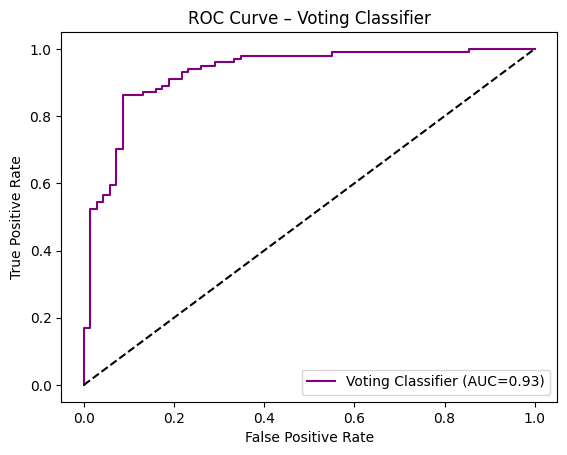

In [ ]:
# Stacking
stack_estimators = [
    ("xgb", best_estimators["XGBoost"]),
    ("cat", best_estimators["CatBoost"]),
    ("rf", best_estimators["RandomForest"]),
    ("svm_rbf", best_estimators["SVM_RBF"]),
    ("svm_poly", best_estimators["SVM_Poly"]),
]
stacked_model = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=1000)
)
stacked_model.fit(X_train, y_train)

y_pred_stack = stacked_model.predict(X_test)
y_proba_stack = stacked_model.predict_proba(X_test)[:, 1]
print("\n✅ Stacked Model Classification Report")
print(classification_report(y_test, y_pred_stack))
stack_auc = roc_auc_score(y_test, y_proba_stack)
print(f"Stacked Model ROC-AUC: {stack_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
plt.figure()
plt.plot(fpr, tpr, label=f"Stacked Model (AUC={stack_auc:.2f})", color="black")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Stacked Model")
plt.legend()
plt.show()

# Voting (Soft Voting)
voting_model = VotingClassifier(
    estimators=stack_estimators,
    voting="soft"
)
voting_model.fit(X_train, y_train)

y_pred_vote = voting_model.predict(X_test)
y_proba_vote = voting_model.predict_proba(X_test)[:, 1]
print("\n✅ Voting Classifier Classification Report")
print(classification_report(y_test, y_pred_vote))
vote_auc = roc_auc_score(y_test, y_proba_vote)
print(f"Voting Classifier ROC-AUC: {vote_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba_vote)
plt.figure()
plt.plot(fpr, tpr, label=f"Voting Classifier (AUC={vote_auc:.2f})", color="purple")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Voting Classifier")
plt.legend()
plt.show()

# **Feature Importance & SHAP:**


🔍 Feature Importance – RandomForest


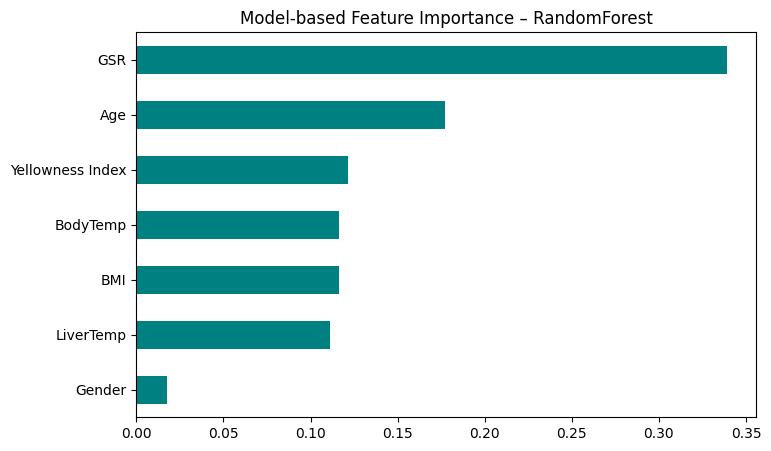

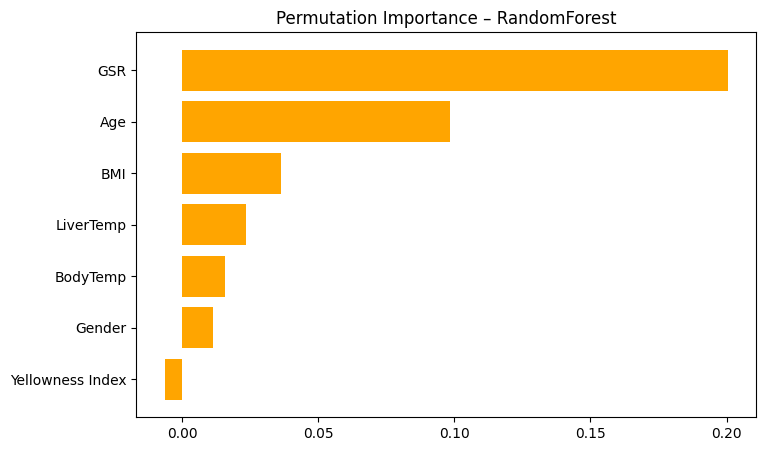

Generating SHAP for RandomForest...


ExactExplainer explainer: 171it [00:56,  2.77it/s]


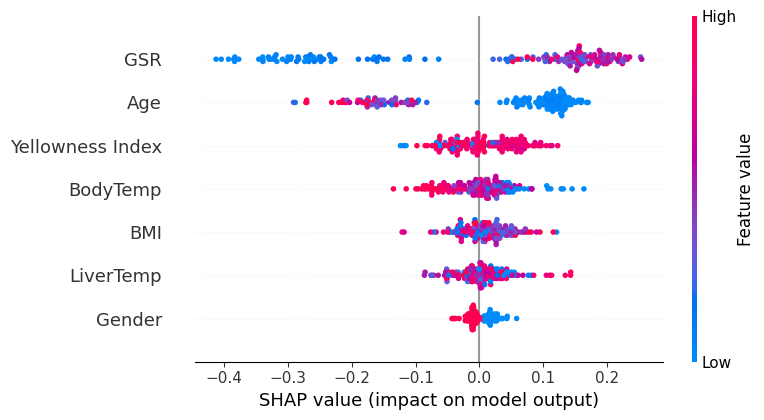


🔍 Feature Importance – LogisticRegression


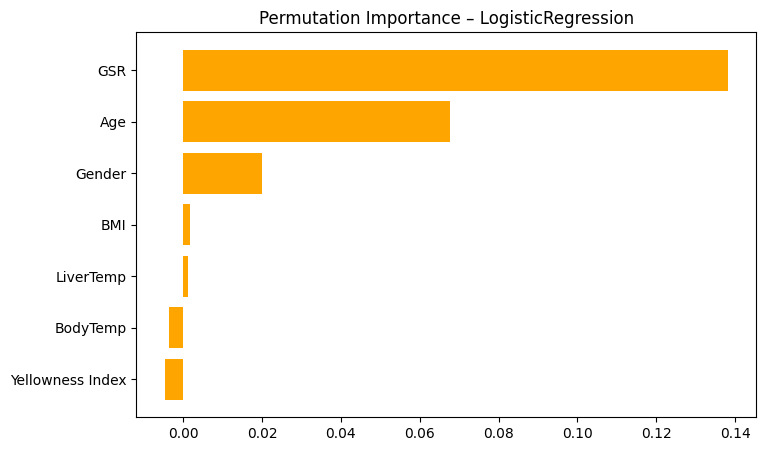

Generating SHAP for LogisticRegression...


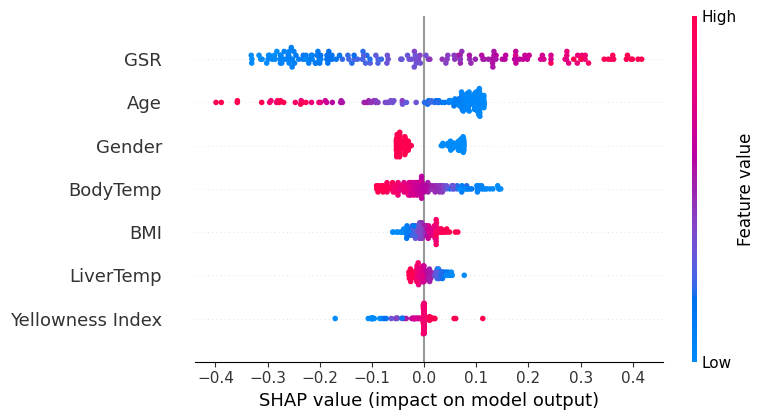


🔍 Feature Importance – SVM_RBF


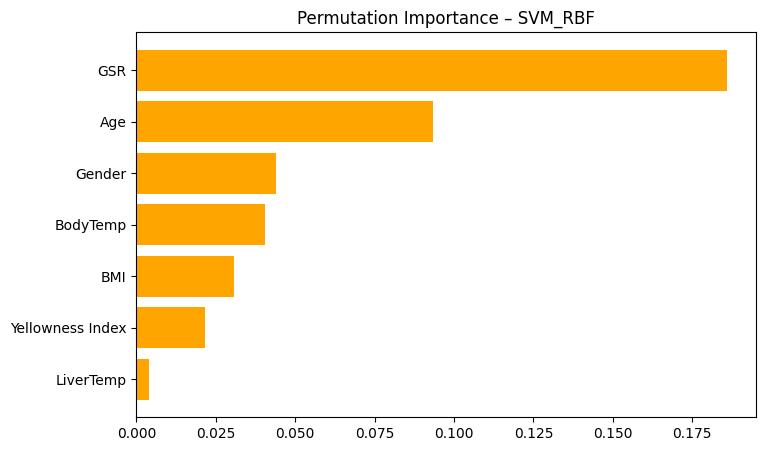

Generating SHAP for SVM_RBF...


ExactExplainer explainer: 171it [00:39,  3.08it/s]


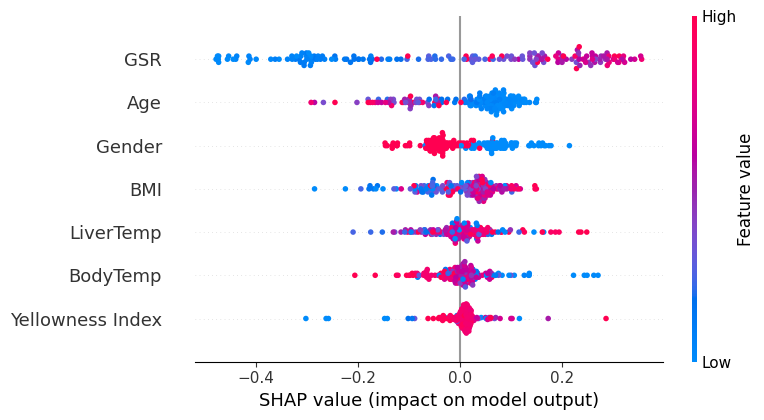


🔍 Feature Importance – SVM_Poly


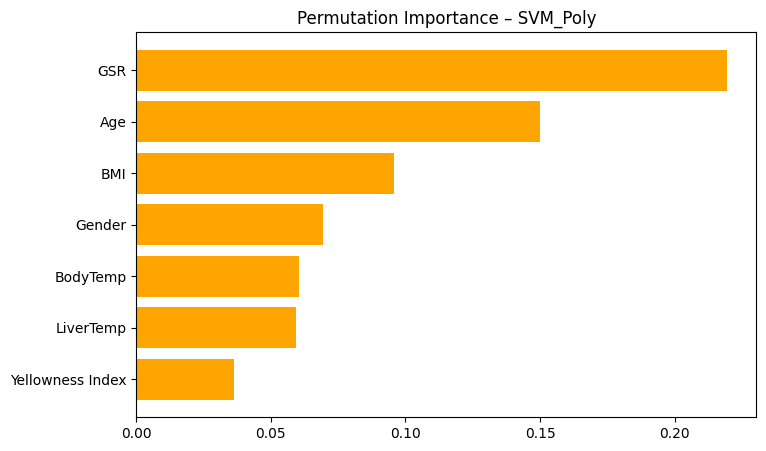

Generating SHAP for SVM_Poly...


ExactExplainer explainer: 171it [00:21,  4.07it/s]                         


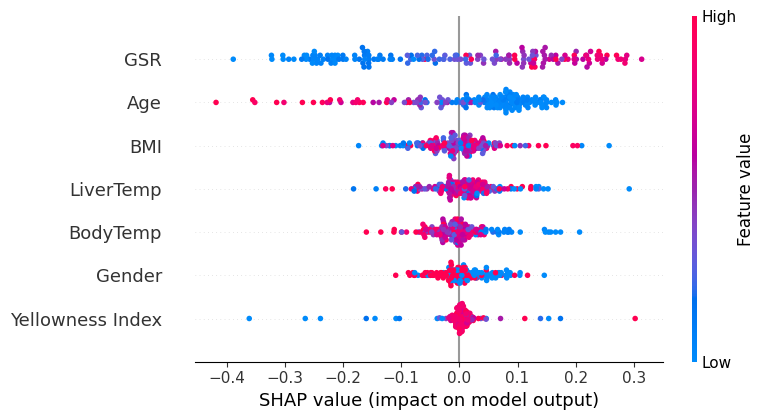


🔍 Feature Importance – XGBoost


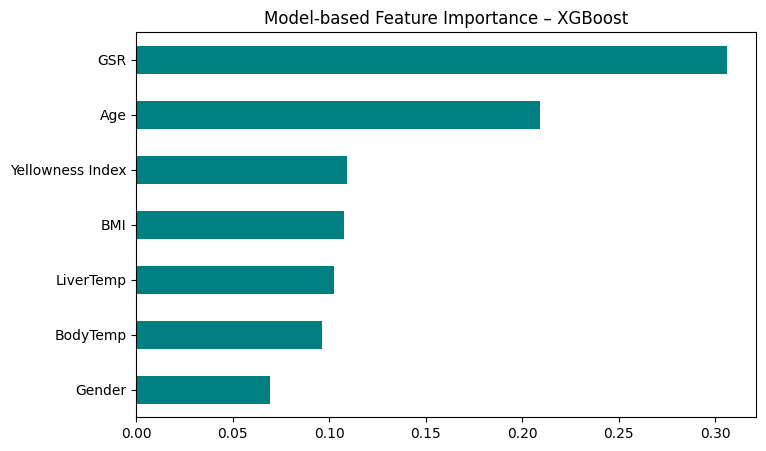

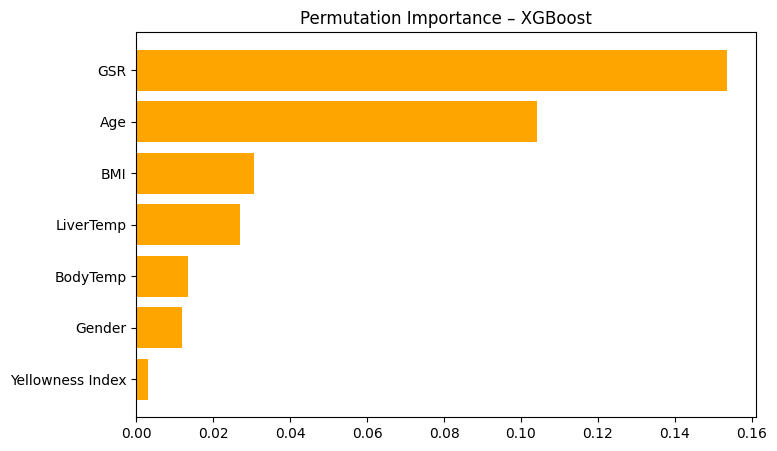

Generating SHAP for XGBoost...


ExactExplainer explainer: 171it [00:12,  3.19it/s]                         


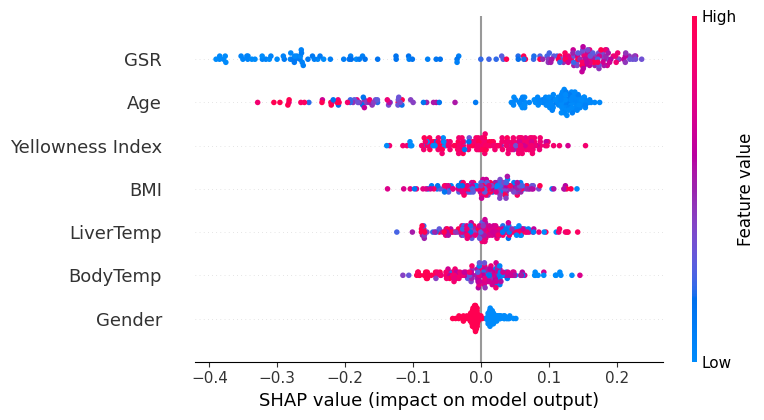


🔍 Feature Importance – CatBoost


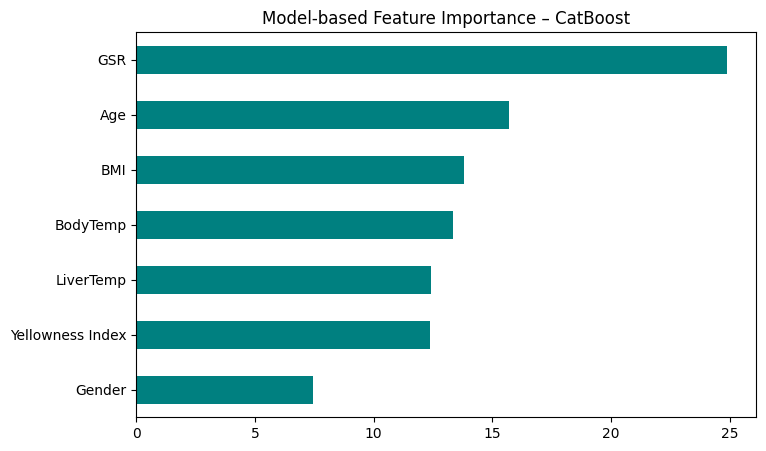

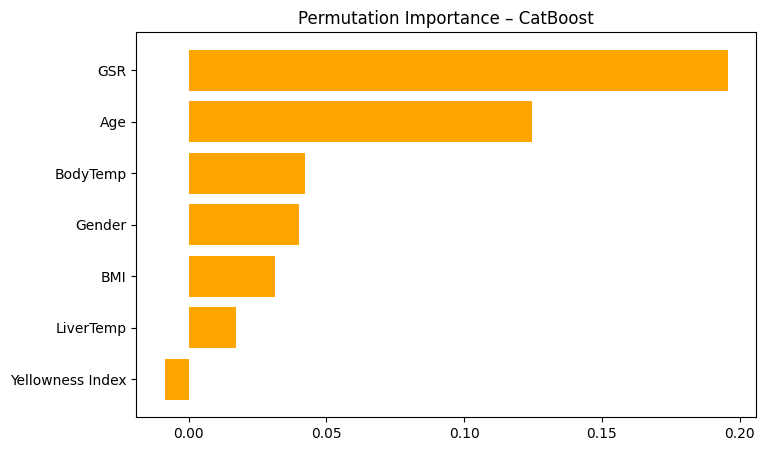

Generating SHAP for CatBoost...


In [ ]:
for name, model in best_estimators.items():
    print(f"\n🔍 Feature Importance – {name}")

    # (1) Model-based (Tree-based models)
    if hasattr(model, "feature_importances_"):
        plt.figure(figsize=(8, 5))
        feat_imp = pd.Series(model.feature_importances_, index=X.columns)
        feat_imp.sort_values().plot(kind="barh", color="teal")
        plt.title(f"Model-based Feature Importance – {name}")
        plt.show()

    # (2) Permutation Importance (All models)
    perm_imp = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
    plt.figure(figsize=(8, 5))
    sorted_idx = perm_imp.importances_mean.argsort()
    plt.barh(np.array(X.columns)[sorted_idx], perm_imp.importances_mean[sorted_idx], color="orange")
    plt.title(f"Permutation Importance – {name}")
    plt.show()

    # SHAP
    print(f"Generating SHAP for {name}...")
    explainer = shap.Explainer(model.predict_proba, X_train)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values[:, :, 1], features=X_test, feature_names=X.columns, show=True)

In [ ]:
import joblib
import os

drive_base_path = "/content/drive/My Drive/"
model_dir = os.path.join(drive_base_path, "LiverGuardDeploy")
os.makedirs(model_dir, exist_ok=True)

joblib.dump(stacked_model, os.path.join(model_dir, "stacked_model.pkl"))
joblib.dump(voting_model, os.path.join(model_dir, "voting_model.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))

print(f"✅ Models and scaler saved at: {model_dir}")

In [ ]:
def preprocess_sensor_input():
    print("\nEnter Real-Time Sensor Data:")

    try:
        age = int(input("Age: "))
        gender = input("Gender (Male/Female): ").strip().capitalize()
        r = float(input("Red Value (R): "))
        g = float(input("Green Value (G): "))
        b = float(input("Blue Value (B): "))
        c = float(input("Intensity value (C): "))
        body_temp = float(input("Body Temperature (°C): "))
        liver_temp = float(input("Liver Temperature (°C): "))
        gsr = float(input("GSR: "))
        bmi = float(input("BMI: "))

        gender_val = 1.0 if gender.lower() == "male" else 0.0

        input_df = pd.DataFrame([{
            "Age": age,
            "Gender": gender_val,
            "R": r,
            "G": g,
            "B": b,
            "C": c,
            "BodyTemp": body_temp,
            "LiverTemp": liver_temp,
            "GSR": gsr,
            "BMI": bmi,
        }])

        # ---- Yellowness Index Calculation ---- #
        R, G, B, C = input_df["R"].astype(float), input_df["G"].astype(float), input_df["B"].astype(float), input_df["C"].astype(float)

        rgb = np.stack([R, G, B], axis=1)
        C_array = C.to_numpy().reshape(-1, 1)
        rgb_norm = rgb / np.clip(C_array, 1e-6, None)
        gray_world_avg_input = np.mean(rgb_norm, axis=0)
        rgb_balanced = np.clip(rgb_norm / (gray_world_avg_input + 1e-6), 0, 1)
        gamma = 2.2
        rgb_linear = np.power(rgb_balanced, gamma)

        M_sRGB_D65 = np.array([
            [0.4124564, 0.3575761, 0.1804375],
            [0.2126729, 0.7151522, 0.0721750],
            [0.0193339, 0.1191920, 0.9503041]
        ])
        xyz = rgb_linear @ M_sRGB_D65.T
        X_coord, Y_coord, Z_coord = xyz[:, 0], xyz[:, 1], xyz[:, 2]
        Cx, Cz = 1.2769, 1.0592
        YI_raw = 100 * (Cx * X_coord - Cz * Z_coord) / np.clip(Y_coord, 1e-6, None)
        yi_min = YI_raw.min()
        yi_max = YI_raw.max()
        yellowness_index = (YI_raw - yi_min) / (yi_max - yi_min + 1e-6)
        input_df["Yellowness Index"] = yellowness_index

        input_df.drop(["R", "G", "B", "C"], axis=1, inplace=True)
        input_scaled = scaler.transform(input_df)

        return input_scaled
    except Exception as e:
        print(f"❌ Error in input or processing: {e}")
        return None

def classify_patient(model_type="stacked"):

    processed = preprocess_sensor_input()
    if processed is None:
        print("❌ Prediction aborted due to preprocessing error.")
        return

    try:
        if model_type == "stacked":
            pred = stacked_model.predict(processed)[0]
        elif model_type == "voting":
            pred = voting_model.predict(processed)[0]
        else:
            print("❌ Invalid model type. Use 'stacked' or 'voting'.")
            return
        if pred == 0:
            result = "Healthy"
        elif pred == 1:
            result = "Unhealthy"
        else:
            result = f"Unknown prediction: {pred}"

        print(f"\n🧠 Final Diagnosis using {model_type.title()} Model: {result}")

    except Exception as e:
        print(f"❌ Error during model prediction: {e}")

classify_patient(model_type="stacked")